# Mix click samples with noise samples from the recorded data

In [1]:
# all libraries used in this notebook
import sys
import os.path
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import necessary functions from the folder "05_Utilities"

cwd = str(Path.cwd()) ## current working directory, should be the path to "01_Dataset", in which this notebook is located
parent_dir = str(Path(cwd).parent) ## parent dir of the current working directory, should be the project directory
utilities_dir_full_path = os.path.join(parent_dir, "05_Utilities") ## full path to the "05_Utilities" folder

# import moduls for audio file processing and mel-spectrogram plotting

sys.path.append(utilities_dir_full_path) ## add the path of the "05_Utilities" folder to the sys.path list
from audioProcessing import processAudio ## modul for audio file processing and mel-spectrogram generation
from spectrogramPlotting import spectrogramPlotter ## modul for mel-spectrogram visualization
from sharedValues import sharedValuesConfig ## modul for shared variables between the classes

# make instances of the classes in the modules
processAudio = processAudio()
spectrogramPlotter = spectrogramPlotter()
sharedValuesConfig = sharedValuesConfig()

In [3]:
# sorting function for files and directories

def sort_key_func(file_name):
        numbers = re.findall(r'\d+', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

In [4]:
# import data from selected dataset

cwd = str(Path.cwd())
parent_dir = os.path.dirname(cwd)
audio_datasets_main_dir = "01_Dataset/01_audioDatasets"
audio_datasets_main_dir = os.path.join(parent_dir, audio_datasets_main_dir)

audio_datasets = []
if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets)
else:
    print("Audio dataset directory does not exist")

print(audio_datasets)


['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples', 'voice_memo_loc_mac.txt']


In [34]:
# load positive samples

dataset_num = 4 # ID of the selected datasets, 0 - ethernet, 2 - hva 280, 4 - hva 630

loaded_spec_chunks = None
loaded_spec_chunk_labels = None

dataset_dir = os.path.join(audio_datasets_main_dir, audio_datasets[dataset_num])
file_list = [f for f in os.listdir(dataset_dir) if f.endswith('.npz')]
print(file_list)
if len(file_list) == 0:
    print(f"No npz file in the directory")
else:
    for file in file_list:
        if file == "ethernet_dataset.npz" or file == "hva280_dataset.npz" or file == "hva630_dataset.npz":
            print(f"Loading file: {file}")
            file_fullpath = os.path.join(dataset_dir, file)

            data = np.load(file_fullpath)

            if loaded_spec_chunks is None:
                loaded_spec_chunks = data['spec_chunks']
                loaded_spec_chunk_labels = data['labels']
            else:
                loaded_spec_chunks = np.concatenate((loaded_spec_chunks, data['spec_chunks']), axis=0)
                loaded_spec_chunk_labels = np.concatenate((loaded_spec_chunk_labels, data['labels']), axis=0)

print(len(loaded_spec_chunks))
print(f"positive samples: {np.count_nonzero(loaded_spec_chunk_labels == 1)}")

# create new numpy array with only positive samples

positive_sample_mask = loaded_spec_chunk_labels == 1

spec_chunks_click = loaded_spec_chunks[positive_sample_mask]
spec_chunk_labels_click = loaded_spec_chunk_labels[positive_sample_mask]

print(len(spec_chunks_click))
print(f"positive samples: {np.count_nonzero(spec_chunk_labels_click == 1)}")

print(np.max(spec_chunks_click))
print(np.min(spec_chunks_click))


['hva630_dataset.npz']
Loading file: hva630_dataset.npz
2640
positive samples: 240
240
positive samples: 240
-14.997096
-120.0


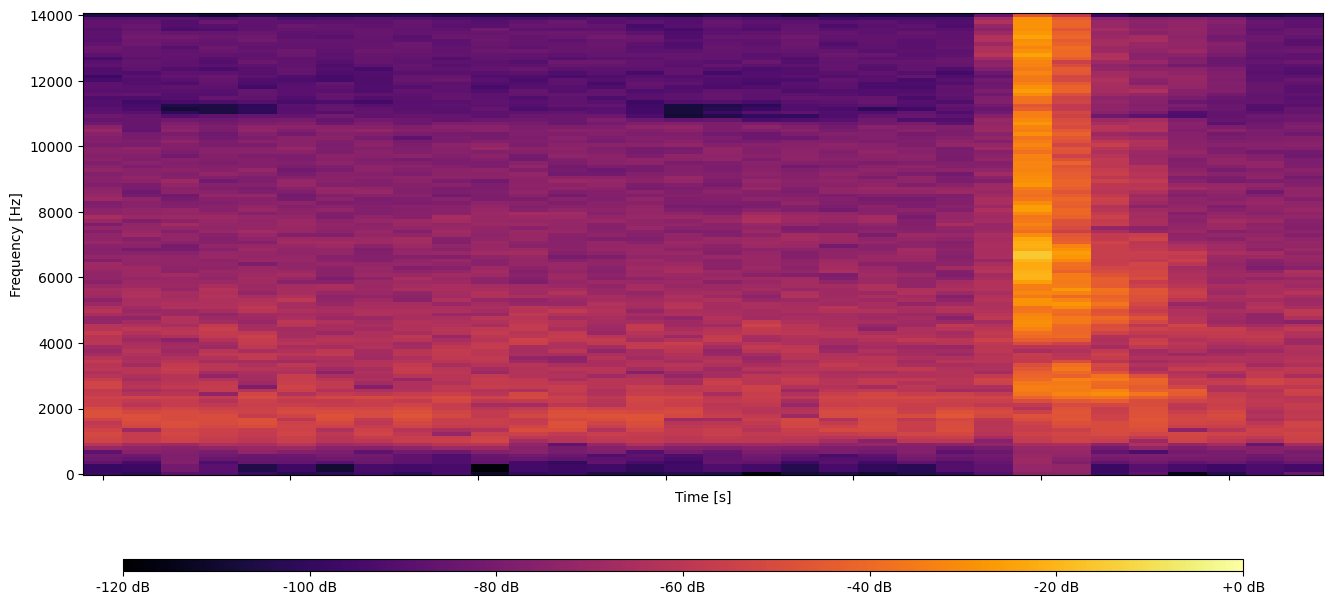

In [35]:
# plot a click mel spectrogram

chunk_id_to_plot = 0

top_dB_abs = 120
f_min = 20
f_max = 14000
n_mels = 128

spectrogramPlotter.plot_single_mel_spectrogram(spec_chunks_click[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels)

In [36]:
# load noise samples

dataset_num_noise = 6 # noise dataset

spec_chunks_noise = None
spec_chunk_labels_noise = None

dataset_dir_noise = os.path.join(audio_datasets_main_dir, audio_datasets[dataset_num_noise])
file_list_noise = [f for f in os.listdir(dataset_dir_noise) if f.endswith('.npz')]

print(file_list_noise)
if len(file_list_noise) == 0:
    print(f"No npz file in the directory")
else:
    if dataset_num == 2:
        file = "noise_dataset_long_window.npz"
    else:
        file = "noise_dataset.npz"

    file_fullpath = os.path.join(dataset_dir_noise, file)
    print(file_fullpath)

    data = np.load(file_fullpath)

    if spec_chunks_noise is None:
        spec_chunks_noise = data['spec_chunks']
        spec_chunk_labels_noise = data['labels']
    else:
        spec_chunks_noise = np.concatenate((spec_chunks_noise, data['spec_chunks']), axis=0)
        spec_chunk_labels_noise = np.concatenate((spec_chunk_labels_noise, data['labels']), axis=0)


# reduce noise level
def reduce_noise_dB(D_mel_dB, noise_reduction_dB_threshold):
    
    D_mel_dB = D_mel_dB * (noise_reduction_dB_threshold/((top_dB_abs/(top_dB_abs-noise_reduction_dB_threshold))*noise_reduction_dB_threshold)) - noise_reduction_dB_threshold

    return D_mel_dB

noise_reduction_dB_threshold_abs = 20
spec_chunks_noise_reduced = np.copy(spec_chunks_noise)
for i in range(len(spec_chunks_noise_reduced)):
    spec_chunks_noise_reduced[i] = reduce_noise_dB(spec_chunks_noise_reduced[i], noise_reduction_dB_threshold_abs)



print(len(spec_chunks_noise))
print(f"positive samples: {np.count_nonzero(spec_chunk_labels_noise == 1)}")

print(np.max(spec_chunks_noise))
print(np.min(spec_chunks_noise))

print(len(spec_chunks_noise_reduced))
print(np.min(spec_chunks_noise_reduced))
print(np.max(spec_chunks_noise_reduced))

['noise_dataset_long_window.npz', 'noise_dataset.npz']
/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/01_Dataset/01_audioDatasets/07_Noise_Samples/noise_dataset.npz
2538
positive samples: 0
0.0
-120.0
2538
-120.0
-20.0


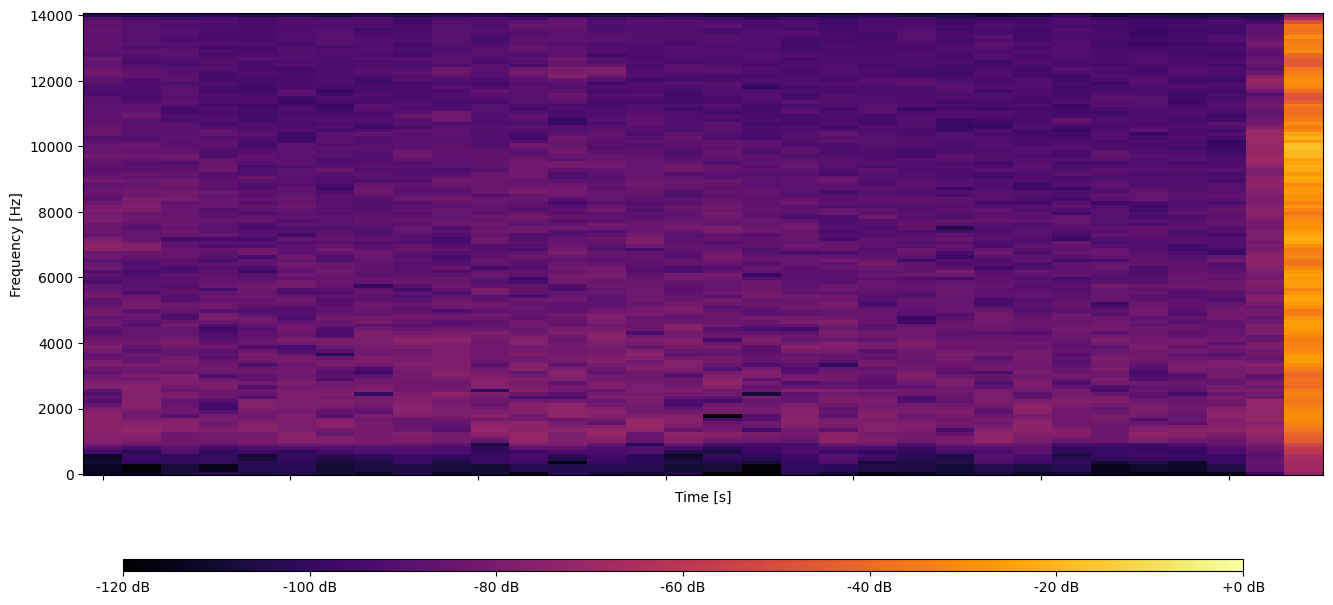

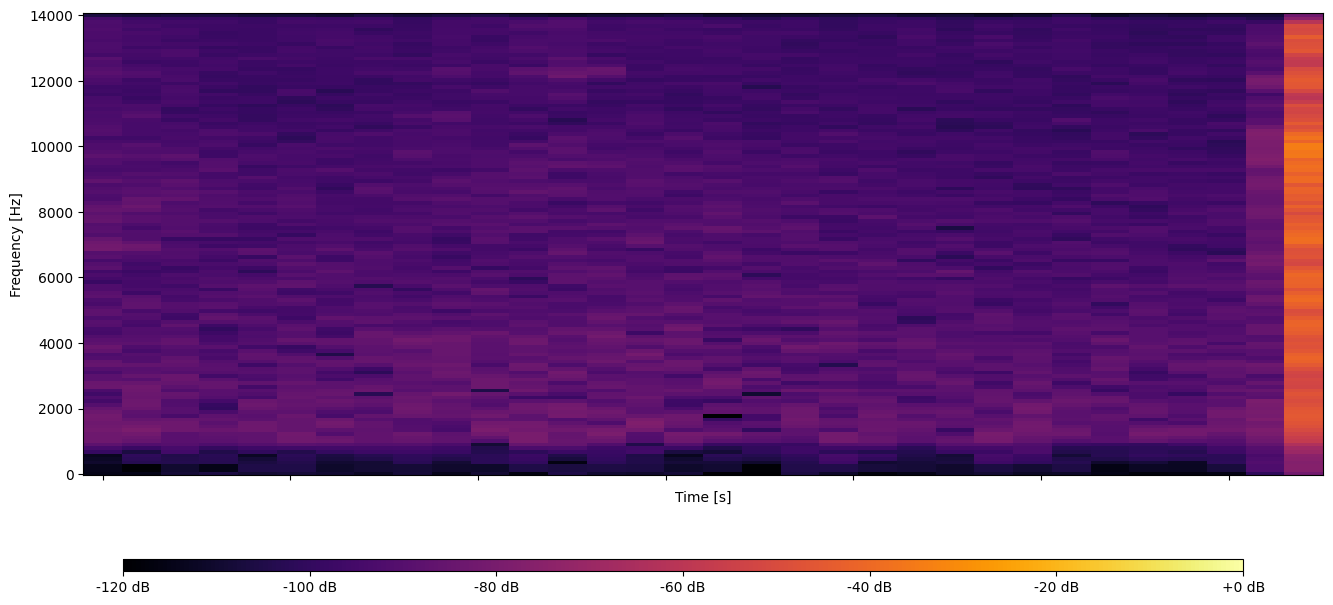

In [37]:
# plot a noise mel spectrogram

noise_chunk_id_to_plot = 0

spectrogramPlotter.plot_single_mel_spectrogram(spec_chunks_noise[noise_chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels)

# plot reduced sample
spectrogramPlotter.plot_single_mel_spectrogram(spec_chunks_noise_reduced[noise_chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels)

In [38]:
# convert back from dB to power

# pover_mel_to_dB conversion: D_mel_dB = 10.0 * np.log10(np.maximum(a_squere_min, np.minimum(D_mel, dB_ref))/dB_ref)
# as adding two signals is possible in power domain (Roberts 1984), spectogram chunks have to be converted back first to power domain

# create a copy of spec_chunks_click
spec_chunks_click_power = np.copy(spec_chunks_click)
spec_chunks_noise_power = np.copy(spec_chunks_noise)
spec_chunks_noise_reduced_power = np.copy(spec_chunks_noise_reduced)

dB_ref = 1e3

def db_to_power_mel(D_mel_dB, dB_ref):

        D_mel = np.power(10.0, D_mel_dB/10) * dB_ref

        return D_mel

for i in range(len(spec_chunks_click_power)):
    spec_chunks_click_power[i] = db_to_power_mel(spec_chunks_click_power[i], dB_ref)

for i in range(len(spec_chunks_noise_power)):
    spec_chunks_noise_power[i] = db_to_power_mel(spec_chunks_noise_power[i], dB_ref)

for i in range(len(spec_chunks_noise_reduced_power)):
    spec_chunks_noise_reduced_power[i] = db_to_power_mel(spec_chunks_noise_reduced_power[i], dB_ref)

print(len(spec_chunks_click_power))
print(np.max(spec_chunks_click_power))

print(len(spec_chunks_noise_power))
print(np.max(spec_chunks_noise_power))
print(spec_chunks_noise_power[0].shape)

print(len(spec_chunks_noise_reduced_power))
print(np.max(spec_chunks_noise_reduced_power))
print(spec_chunks_noise_reduced_power[0].shape)


240
31.643927
2538
1000.0
(128, 32)
2538
10.0
(128, 32)


In [39]:
# mix click samples and samples with reduced noise

np.random.seed(42) # for reproducibility

# upsample click data to noise sample number
spec_chunks_click_power_upsampled = spec_chunks_click_power[np.random.choice(len(spec_chunks_click_power), 
                                                                             len(spec_chunks_noise_power), 
                                                                             replace=True)].copy()
print(len(spec_chunks_click_power_upsampled))

spec_chunks_click_power_upsampled_copy = spec_chunks_click_power_upsampled.copy()
spec_chunks_noise_power_copy = spec_chunks_noise_power.copy()
spec_chunks_noise_reduced_power_copy = spec_chunks_noise_reduced_power.copy()

np.random.shuffle(spec_chunks_click_power_upsampled_copy)
np.random.shuffle(spec_chunks_noise_power_copy)
np.random.shuffle(spec_chunks_noise_reduced_power_copy)

spec_chunks_click_augmented_power = spec_chunks_click_power_upsampled_copy + spec_chunks_noise_reduced_power_copy

2538


In [40]:
# convert back to dB

spec_chunks_click_augmented_dB = np.copy(spec_chunks_click_augmented_power)

a_squere_min = 1e-12

def power_mel_to_db(D_mel, a_squere_min, dB_ref):

        D_mel_dB = 10.0 * np.log10(np.maximum(a_squere_min, np.minimum(D_mel, dB_ref)/dB_ref))

        return D_mel_dB

for i in range(len(spec_chunks_click_augmented_dB)):
    spec_chunks_click_augmented_dB[i] = power_mel_to_db(spec_chunks_click_augmented_dB[i], a_squere_min, dB_ref)

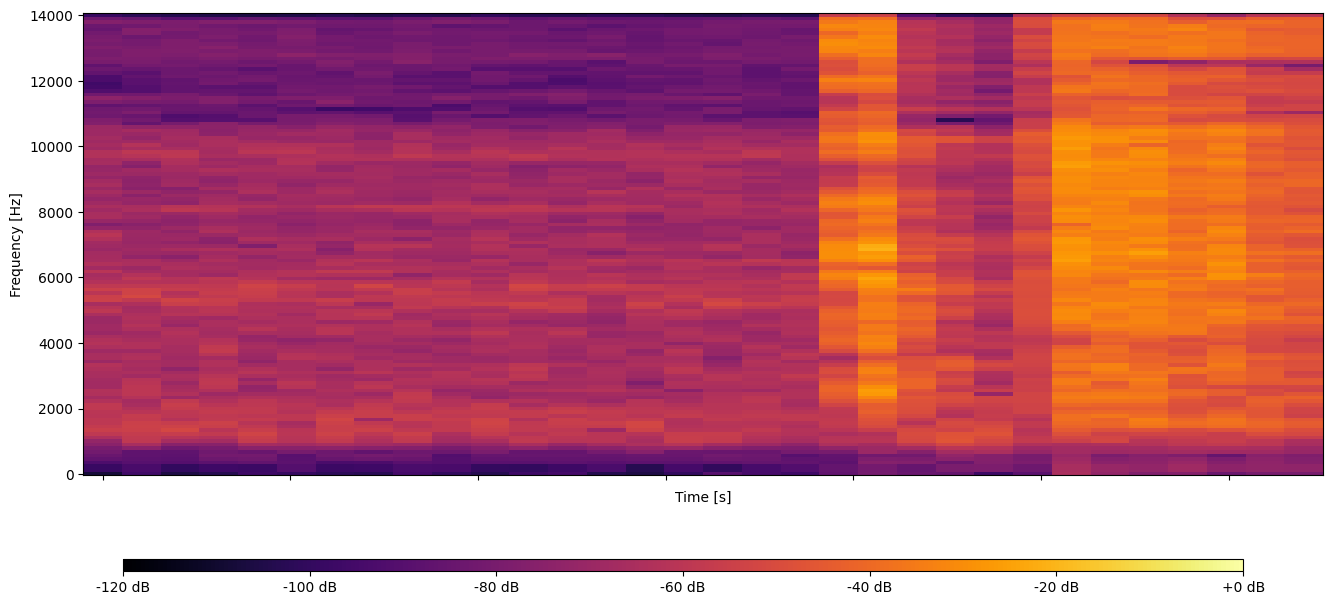

In [41]:
# plot augmented samples

augmented_chunk_id_to_plot = 0

spectrogramPlotter.plot_single_mel_spectrogram(spec_chunks_click_augmented_dB[augmented_chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels)

In [42]:
# create label array with the length of the augmented samples

spec_chunks_click_augmented_dB_labels = np.ones(len(spec_chunks_click_augmented_dB))

print(len(spec_chunks_click_augmented_dB_labels))
print(np.count_nonzero(spec_chunks_click_augmented_dB_labels == 1))


2538
2538


In [43]:
# save the mixed click-noise spectrogram dataset and labels in .npz format

if dataset_num == 0:
    connector = "ethernet"
    augmendet_directory = "01_Ethernet"
elif dataset_num == 2:
    connector = "hva280"
    augmendet_directory = "02_HVA280"
elif dataset_num == 4:
    connector = "hva630"
    augmendet_directory = "03_HVA630"

save_directory = os.path.join(cwd, "01_augmentedDatasets", augmendet_directory)
filename = f"{connector}_dataset_augmented_w_recorded_noise.npz"
file_fullpath = os.path.join(save_directory, filename)

spec_chunk_dataset = np.array(spec_chunks_click_augmented_dB)
spec_chunk_labels = np.array(spec_chunks_click_augmented_dB_labels)

#print(np.min(spec_chunk_dataset), np.max(spec_chunk_dataset))

np.savez(file_fullpath, spec_chunks=spec_chunk_dataset, labels=spec_chunk_labels)